In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy as sc
from scipy.optimize import curve_fit # For fitting redshift distribution
from scipy.optimize import newton    # For finding roots to nonlinear equation
import scipy.integrate as integrate  # For integration

from PIL import Image
import pylab                         # For generating contours of image

from astropy.coordinates import Distance    # For changing from redshift to distance
from astropy.cosmology import WMAP7, WMAP9  # For changing from redshift to distance
from astropy import units as u

# For auxiliary functions
import time
import sys

$$AU = 149.6 \text{ million km}$$

$$\text{parsec} = 3.26 \text{ light years } = 30.9 \text{ trillion km}$$

$$H_0 = 70 km/s/Mpc$$

$$M_\odot = 2\times 10^{30}kg$$

$$r_\odot = 7\times 10^{8}km$$

In [2]:
# Defining constants
c = 3e+8             # speed of light in m/s
AU = 1.5e+11       # astronomical unit = 149.6 million km
G = 6.67e-11      # Gravitational constant in Nm^2 kg^-2 == m^3 kg^-1 s^-2
pc = 3e+16       # parsec = 3.26 light years = 206,000 AU = 30.9 trillion km
Gpc = 1e9*pc
H_0 = 70e3           # Cosmological constant in m/(s Mpc)

# Defining radius and mass parameters of the system
M_sun = 2e+30    # in kg
M_earth = 6e+24 / M_sun # in solar masses
r_sun = 7e+8    # 696,340 km
r_earth = 6.4e+6/AU    # 6371 km, variable in AU

rho_crit_0 = 9.21e-27 / M_sun    # critical density in solar masses per m^3
Omega_DM = 0.26

Lagrange Point under reduced mass constraint $$R_{L_2} = R\left(\frac{M_2}{3M_1}\right)^{1/3}$$

In [3]:
# Function to calculate location of L2, under reduced mass constraint
# R = distance between two masses M1, M2
# M1 = Mass of the larger object
# M2 = Mass of the smaller object
# https://en.wikipedia.org/wiki/Lagrange_point#L2
# Output: Langrange point distance in AU
def L2_point(R, M1, M2):
    return (R * (M2/(3*M1))**(1/3))

### Redshift vs GRB Distribution

In [4]:
redshift = np.genfromtxt('redshift.csv',delimiter=',')

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


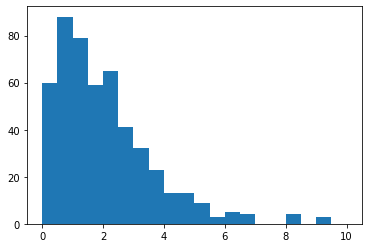

In [5]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(0, 10, 21)
print(bins)
data_entries, bins = np.histogram(redshift, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(redshift, bins = bins)
plt.show()

Poisson distribution: $A.x.e^{-\alpha x} \equiv 495xe^{-1.025x}$

In [6]:
def fit_function(x, A, alpha):
    return (A * x * np.exp(-x*alpha))

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[240,1.3])
print(popt)

[247.52234509   1.02585546]


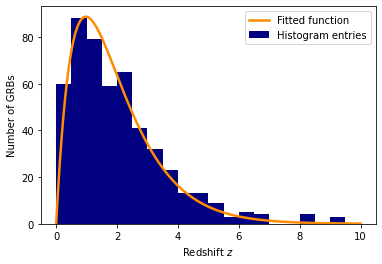

In [7]:
xspace = np.linspace(0, 10, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

Refer [scipy tutorial](https://riptutorial.com/scipy/example/31081/fitting-a-function-to-data-from-a-histogram) for further information

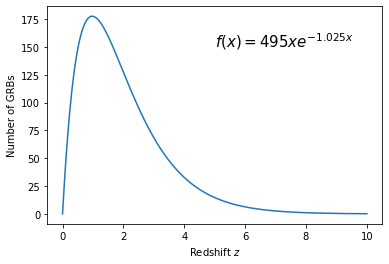

In [8]:
popt2 = np.array([247.52234509, 1.02585546])
popt2[0] /= 0.5
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
plt.plot(xspace, fit_function(xspace,*popt2))
ax.text(5, 150, r'$f(x)=495x e^{-1.025x}$', fontsize=15)
#plt.savefig('distribution accounting for bin size.png')
plt.show()

In [9]:
Num_GRBs = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) # Number of GRBs in +/- 0.05 for a given redshift
GRB_distribution = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) / integrate.quad(Num_GRBs, 0, 10)[0] # GRB progenitor distribution as a function of redshift
Pr_GRB_zS = lambda z_S: integrate.quad(GRB_distribution, z_S - 0.25, z_S + 0.25) # Probability of selected GRB having z_S +/- 0.25 redshift

In [10]:
GRB_dbt_bin_size = 20
Pr_GRB_zS_numeric = np.zeros(GRB_dbt_bin_size)
for i in range(GRB_dbt_bin_size):
    Pr_GRB_zS_numeric[i] = Pr_GRB_zS(10/GRB_dbt_bin_size*i + 10/GRB_dbt_bin_size/2)[0]

In [11]:
Pr_GRB_zS_numeric

array([0.09418673, 0.17967312, 0.18139002, 0.15279999, 0.1179485 ,
       0.08646377, 0.06125533, 0.04235567, 0.02876067, 0.01925626,
       0.01274859, 0.00836301, 0.0054443 , 0.00352139, 0.00226507,
       0.00144999, 0.00092433, 0.00058706, 0.00037163, 0.00023457])

In [12]:
# Block to randomly sample points from GRB progenitor distribution
num_GRB_samples = 1000
l = []
for i in range(GRB_dbt_bin_size):
    for j in range(int(Pr_GRB_zS_numeric[i]*10000)): # 10000 multiplier covers 99.88% of the population space, 1000 -> 99.0%, 100000 -> 99.99%
        l.append(np.random.rand()/2 + i*10/GRB_dbt_bin_size)

In [13]:
GRB_list_redshift = np.array(l)
np.random.shuffle(GRB_list_redshift)

In [14]:
np.size(GRB_list_redshift)

9988

In [15]:
sim_GRB_list_redshift = np.zeros(num_GRB_samples)
size_GRB_list_redshift = np.shape(GRB_list_redshift)[0]
for i in range(num_GRB_samples):
    sim_GRB_list_redshift[i] = GRB_list_redshift[np.random.randint(size_GRB_list_redshift)]

In [16]:
np.min(sim_GRB_list_redshift),np.max(sim_GRB_list_redshift)

(0.00014882165999935415, 7.901130043408261)

### Source Star Radius vs GRB Distribution

In [17]:
source_star = np.genfromtxt('source_star.csv',delimiter=',')

[-2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2]


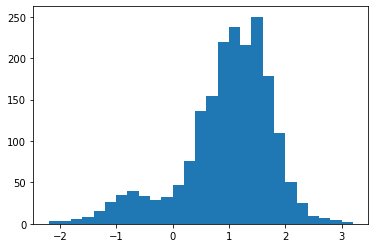

In [18]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(-2.2, 3.2, 28)
print(bins)
data_entries, bins = np.histogram(source_star, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(source_star, bins = bins)
plt.show()

Double Gaussian Distribution: $c_1.e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} + c_2.e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}}$

In [19]:
def fit_function(x, c1, mu1, sigma1, c2, mu2, sigma2):
    return (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[50,-1,1,250,1,2])
print(popt)

[ 34.34949502  -0.67785818  -0.55209415 248.51853339   1.20256234
   0.55588398]


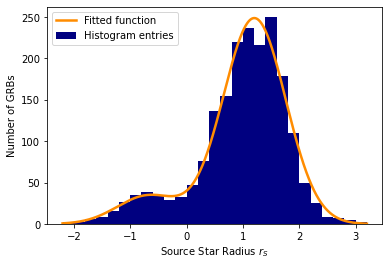

In [20]:
xspace = np.linspace(-2.2, 3.2, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Source Star Radius $r_S$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

In [21]:
source_star_2 = source_star
np.random.shuffle(source_star_2)
sim_GRB_list_ss = np.zeros(num_GRB_samples)
size_GRB_list_ss = np.shape(source_star)[0]
for i in range(num_GRB_samples):
    sim_GRB_list_ss[i] = source_star_2[np.random.randint(size_GRB_list_ss)] - 0.1 + 0.2*np.random.rand()

In [22]:
np.min(sim_GRB_list_ss),np.max(sim_GRB_list_ss)

(-2.1538508079184884, 2.999085382290856)

Einstein Angle $$\theta_E = \sqrt{\frac{4GM}{c^2}\frac{1}{D}} = \sqrt{\frac{4GM}{c^2}\frac{D_{LS}}{D_L D_S}}$$

Einstein Radius $$r_E = \theta_e D_L$$

In [23]:
# Function to calculate Einstein angle of a lensing system
# M = mass of the lens
# D = Effective lensing distance
# Output: Einstein angle in radians
def Einstein_angle(M, D):
    return np.sqrt((4*G*(M*M_sun))/(c**2 * (D*Gpc)))

In [24]:
num_samples = num_GRB_samples

# Defining lensing system parameters (lengths)
DS = WMAP9.comoving_distance(sim_GRB_list_redshift).value/1e3    # Distance between source and observer in Gpc
r_S = sim_GRB_list_ss

Comoving Distance $$\int_0^z \frac{cdz}{H(z)}$$
where $$H(z) = \sqrt{(1+z)^3\Omega_m + (1+z)^4\Omega_r + \Omega_\Lambda}$$

[Source](https://docs.astropy.org/en/stable/cosmology/index.html)

In [25]:
Hofz_inv = lambda z: 1/(H_0*np.sqrt(0.69 + (1+z)**3*0.31))
dcomoving = c*integrate.quad(Hofz_inv, 0, 2)[0]/1e3
print(dcomoving, WMAP9.comoving_distance(2).value/1e3)    # In Gpc

5.13967702165249 5.291730374382688


(array([191., 284., 248., 103.,  76.,  50.,  29.,   9.,   6.,   4.]),
 array([1.48821660e-04, 7.90246944e-01, 1.58034507e+00, 2.37044319e+00,
        3.16054131e+00, 3.95063943e+00, 4.74073755e+00, 5.53083568e+00,
        6.32093380e+00, 7.11103192e+00, 7.90113004e+00]),
 <BarContainer object of 10 artists>)

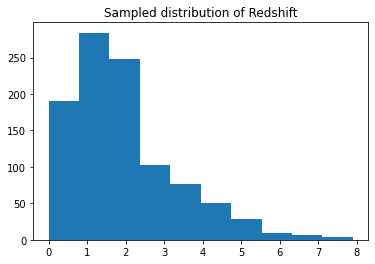

In [26]:
plt.title('Sampled distribution of Redshift')
plt.hist(sim_GRB_list_redshift)

(array([ 45.,  29., 108., 121., 165., 184., 145., 107.,  77.,  19.]),
 array([6.43597575e-04, 9.15001814e-01, 1.82936003e+00, 2.74371825e+00,
        3.65807646e+00, 4.57243468e+00, 5.48679290e+00, 6.40115111e+00,
        7.31550933e+00, 8.22986754e+00, 9.14422576e+00]),
 <BarContainer object of 10 artists>)

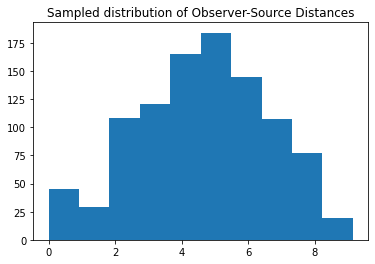

In [27]:
plt.title('Sampled distribution of Observer-Source Distances')
plt.hist(DS)

(array([  3.,  14.,  40.,  55.,  91., 215., 299., 224.,  50.,   9.]),
 array([-2.15385081, -1.63855719, -1.12326357, -0.60796995, -0.09267633,
         0.42261729,  0.93791091,  1.45320453,  1.96849814,  2.48379176,
         2.99908538]),
 <BarContainer object of 10 artists>)

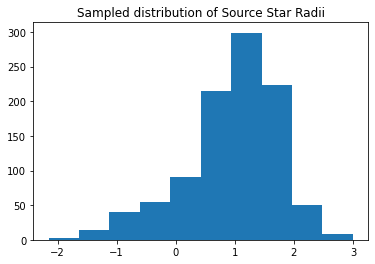

In [28]:
plt.title('Sampled distribution of Source Star Radii')
plt.hist(r_S)

In [29]:
# Option 1 = Conservative
# Option 2 = Optimistic

option = 2

if option == 1:
    epsilon = 0.1
    NGRB = 10**3
    #Delta_r = np.array(((2*r_earth) / AU, L2_point(R, 1, M_earth), 2))     # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU
elif option == 2:
    epsilon = 0.01
    NGRB = 10**4
    #Delta_r = np.array(((2*r_earth) / AU, L2_point(R, 1, M_earth), 2))     # distances in AU
                                                                           # def L2_point(R, M1, M2)
                                                                           # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU

### Appendix B: Finite source-size effect

In [30]:
# Function to calculate A_in
# Output: A_in
def A_in(u, delta):
    return (np.sqrt(1+ 4/(delta**2)) - 8 / (delta**3 * (delta**2 + 4)**1.5) * u**2/2 - 144 * (delta**4 + 2*delta**2 + 2) / (delta**5 * (delta**2 + 4)**3.5) * u**4/24)
    
# Function to calculate A_out
# Output: A_out
def A_out(u, delta):
    return ((2 + u**2) / (u*np.sqrt(u**2 + 4)) + (8*(u**2 + 1)) / (u**3 * (u**2 + 4)**2.5) * delta**2/2 + 48*(3*u**6 + 6*u**4 + 14*u**2 + 12) / (u**5 * (u**2 + 4)**4.5) * delta**4/24)

def A_intermediate(u, delta):
    return (A_out(1.1*delta, delta)*(u - 0.9*delta)/(0.2*delta) + A_in(0.9*delta, delta)*(1.1*delta - u)/(0.2*delta))

# Function to calculate the magnification of a finite sized circular source with constant surface brightness by a point-lens in the geometrical optics limit
# r_S = source size
# D = Effective lensing distance
# theta_E = Einstein angle
# u = Position of the source
# Output: Magnification
def finite_source_size_effect(r_S, D, theta_E, u, num_sides):
    
    A = np.zeros([num_sides,num_sides])
    theta_S = r_S/(D * Gpc)
    delta = theta_S/theta_E
    
    Obs = np.where(u <= 0.9*delta, A_in(u, delta), 0)
    Obs += np.where(u >= 1.1*delta, A_out(u, delta), 0)
    Obs += np.where((u > 0.9*delta)&(u < 1.1*delta), A_intermediate(u, delta), 0)
    
    return Obs

In [31]:
# Simulating lens plane position of detectable dark matter
# ACTIVE BLOCK

def sim_lens_plane(epsilon, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, Delta_r, DS, x_lens, num_sides, theta, grid_length_factor):

    r_S = GRB_progenitor_size_factor * r_sun
    M = np.logspace(start_mass, end_mass, num_masses)
    theta_E = np.zeros(num_masses)

    DL = x_lens*DS
    DLS = DS - DL
    D = DS*DL/DLS
    
    Delta_r = Delta_r*np.cos(theta)

    arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))
    arr_lens_plane_pos_2 = np.zeros((num_masses,num_sides,num_sides))

    beta1 = np.zeros(num_sides)
    beta2 = np.zeros(num_sides)
    u1 = np.zeros([num_sides,num_sides])
    u2 = np.zeros([num_sides,num_sides])
    u_single = np.zeros([num_sides, num_sides])

    count = np.zeros(num_masses)
    pixel_length_x = np.zeros(num_masses)
    pixel_length_y = np.zeros(num_masses)
    grid_length_x = 0
    grid_length_y = 0
    
    # Calculating Einstein angles for each mass of lens
    for k in range(num_masses):
        theta_E[k] = Einstein_angle(M[k],D)
    print(' ')

    max_A = 0
    max_u = 0

    for k in range(num_masses):

        calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u, num_sides)

        print('Iteration:',k)

        grid_length_x = (2*grid_length_factor*theta_E[k] + Delta_r/D)
        grid_length_y = (2*grid_length_factor*theta_E[k] + Delta_r/D)
        
        pixel_length_x[k] = grid_length_x/num_sides
        pixel_length_y[k] = grid_length_y/num_sides

        for j in range(num_sides):
            
            tmp_x = (np.arange(int(-num_sides/2), int(num_sides/2)) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]
            
            beta1 = np.sqrt((tmp_x - Delta_r/2/D)**2 + tmp_y**2)
            beta2 = np.sqrt((tmp_x + Delta_r/2/D)**2 + tmp_y**2)
            
            u1[j] = beta1/theta_E[k]
            u2[j] = beta2/theta_E[k]
            
            u_single[j] = np.sqrt((tmp_x)**2 + (tmp_y)**2)/theta_E[k]
                
        A1 = calc_finite(u1)
        A2 = calc_finite(u2)
        
        A_single = calc_finite(u_single)

        arr_lens_plane_pos[k] = 2*np.abs(A1 - A2)/(A1 + A2)
        count[k] = (arr_lens_plane_pos[k]>epsilon).sum()
        #arr_lens_plane_pos[k] = np.where(arr_lens_plane_pos<epsilon,0,arr_lens_plane_pos[k])

    print(' ')
    print("count=",count) 
    print(' ')
    
    return (arr_lens_plane_pos, A_single, theta_E, pixel_length_x, pixel_length_y, M, grid_length_x, grid_length_y, count)

 
Iteration: 0
 
count= [1776.]
 


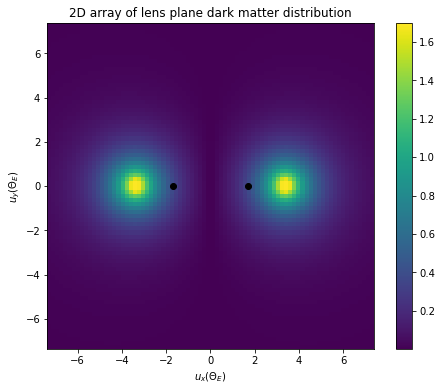

Mass of lens = 1e-11
Maximum value of observable flux 1.6989357122225737
Area of bright cells = 7.246795837640591e+43


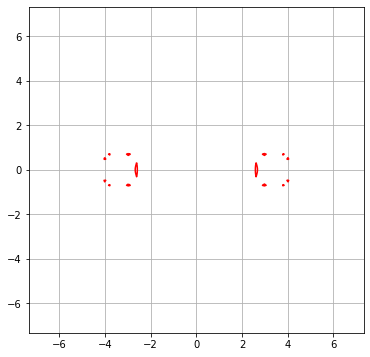

In [32]:
# epsilon, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, Delta_r, DS, x_lens, num_sides, theta
epsilon_input = 0.1
GRB_progenitor_size_factor = 0.1
Delta_r = np.array([2*AU/Gpc, L2_point(AU/Gpc,1,M_earth), 2*r_earth/Gpc])
theta = 0

present_Delta_r = Delta_r[1]

num_masses = 1
start_mass = -11
end_mass = -11

DS_input = 1
x_lens = 0.1

num_sides = 80
grid_length_factor = 2

[arr_lens_plane_pos, A_single, theta_E, pixel_length_x, pixel_length_y, M, grid_length_x, grid_length_y, count] = sim_lens_plane(epsilon_input, GRB_progenitor_size_factor, num_masses, start_mass, end_mass, present_Delta_r, DS_input, x_lens, num_sides, theta, grid_length_factor)

k = 0
DL_input = x_lens * DS_input


fig = plt.figure(figsize=(8,6))
pixel_extent = grid_length_x/theta_E[k]
#pixel_length_x[k]/(DL_input*theta_E[k]/num_sides)/2
plt.imshow(arr_lens_plane_pos[k], extent=[-pixel_extent, pixel_extent, -pixel_extent, pixel_extent])#, norm=colors.LogNorm(), vmin=epsilon_input, vmax=np.max(arr_lens_plane_pos))
plt.title("2D array of lens plane dark matter distribution")
#plt.grid()

plt.xlabel('$u_x(\Theta_E)$')
plt.ylabel("$u_y(\Theta_E)$")

plt.colorbar()
plt.scatter([present_Delta_r/2/DS_input*(1/x_lens-1)/theta_E[k], - present_Delta_r/2/DS_input*(1/x_lens-1)/theta_E[k]], [0,0], c='black')
plt.show()
print("Mass of lens =",M[k])
print("Maximum value of observable flux",np.max(arr_lens_plane_pos[k]))
print("Area of bright cells =", (count[k]*pixel_length_x[k]*Gpc*pixel_length_y[k]*Gpc) * DS_input *Gpc * x_lens**2)

image = Image.fromarray(np.uint8(arr_lens_plane_pos[k] * 255), 'L')
new_image = image.resize((int(200*pixel_length_x[k]/pixel_length_y[k]), 200))

fig = plt.figure(figsize=(6,6))
pylab.contour(new_image, extent=[-pixel_extent, pixel_extent, -pixel_extent, pixel_extent], levels=[245], colors='red', origin='image')
plt.grid()

In [33]:
tmp_x = np.array([2.79E+43,
4.41E+43,
5.49E+43,
6.28E+43,
6.89E+43,
7.27E+43,
7.53E+43,
7.60E+43,
7.49E+43,
7.39E+43,
7.12E+43,
6.80E+43,
6.33E+43,
5.93E+43,
5.41E+43,
4.80E+43,
4.21E+43,
3.59E+43,
2.96E+43,
2.34E+43,
1.72E+43,
1.13E+43,
6.15E+42,
2.01E+42,])
tmp_y = np.arange(24)/25 + 0.04

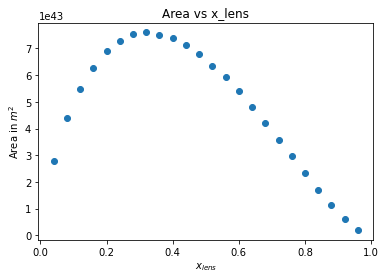

In [34]:
plt.title('Area vs x_lens')
plt.scatter(tmp_y,tmp_x)
plt.ylabel('Area in $m^2$')
plt.xlabel('$x_{lens}$')
plt.show()

In [35]:
# Simulating lens plane position of detectable dark matter for single mass and calculating volume
# ARCHIVE
def single_mass_volume(epsilon, GRB_progenitor_size_factor, M_input, Delta_r, theta, redshift_input, num_sides, grid_length_factor):

    r_S = GRB_progenitor_size_factor*r_sun#sim_GRB_list_ss
    
    num_masses = 1
    M = np.array([M_input])
    theta_E = np.zeros(num_masses)
    Delta_r = Delta_r * np.cos(theta)
    
    DS = WMAP9.comoving_distance(redshift_input).value/1e3
    chi_S = DS*Gpc
    n_quad = 25
    x_lens = np.arange(1,n_quad)/n_quad

    arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

    beta1 = np.zeros(num_sides)
    beta2 = np.zeros(num_sides)
    u1 = np.zeros([num_sides, num_sides])
    u2 = np.zeros([num_sides, num_sides])

    count = np.zeros(num_masses)
    grid_length_x = np.zeros(num_masses)
    grid_length_y = np.zeros(num_masses)
    pixel_length_x = np.zeros(num_masses)
    pixel_length_y = np.zeros(num_masses)

    sigma_lens = np.zeros(np.size(x_lens))
    V_lens = 0

    k=0

    for l in range(np.size(x_lens)):

        DL = x_lens[l]*DS
        DLS = DS - DL
        D = DL*DS/DLS
        D = 1
        theta_E[k] = Einstein_angle(M[k],D)
        calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u, num_sides)

        grid_length_x = (2*grid_length_factor*theta_E[k] + Delta_r/D)
        grid_length_y = (2*grid_length_factor*theta_E[k] + Delta_r/D)
        
        pixel_length_x[k] = grid_length_x/num_sides
        pixel_length_y[k] = grid_length_y/num_sides

        for j in range(num_sides):
            
            tmp_x = (np.arange(int(-num_sides/2), int(num_sides/2)) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]
            
            beta1 = np.sqrt((tmp_x - Delta_r/2/D)**2 + tmp_y**2)
            beta2 = np.sqrt((tmp_x + Delta_r/2/D)**2 + tmp_y**2)
            
            u1[j] = beta1/theta_E[k]
            u2[j] = beta2/theta_E[k]
                
        A1 = calc_finite(u1)
        A2 = calc_finite(u2)

        arr_lens_plane_pos[k] = 2*np.abs(A1 - A2)/(A1 + A2)
        count[k] = (arr_lens_plane_pos[k] > epsilon).sum()

        sigma_lens[l] = (count[k]*pixel_length_x[k]*Gpc*pixel_length_y[k]*Gpc) * chi_S * x_lens[l]**2
        #print("count:",count[k])
        #print("Iteration:", l)
        #print("count:",count[k])
        #print("Area:", sigma_lens[l])
        count[k] = 0

    # Midpoint quadrature rule
    h = (np.max(x_lens)-np.min(x_lens))/np.size(x_lens)

    # V_lens = h*(f(a)/2 + f(a+h) + f(a+2h) + ... f(b))
    V_lens = sigma_lens[0]/2 + sigma_lens[np.size(x_lens)-1]/2
    for l in range(1,np.size(x_lens)-1):
        V_lens += sigma_lens[l]
    V_lens *= h
    #print("Volume occupied by Lens:",V_lens)

    #print('')
    
    return (V_lens)

In [36]:
# Simulating lens plane position of detectable dark matter for single mass and calculating volume
def multiple_masses_volume(epsilon, GRB_progenitor_size_factor, M_input, Delta_r, theta, redshift_input, num_sides, pixel_length_factor):

    r_S = GRB_progenitor_size_factor*r_sun#sim_GRB_list_ss
    
    num_masses = 1
    M = np.array([M_input])
    theta_E = np.zeros(num_masses)
    Delta_r = Delta_r * np.cos(theta)
    
    DS = WMAP9.comoving_distance(redshift_input).value/1e3
    chi_S = DS*Gpc
    n_quad = 25
    x_lens = np.arange(1,n_quad)/n_quad

    arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

    beta1 = np.zeros(num_masses, num_sides)
    beta2 = np.zeros(num_masses, num_sides)
    u1 = np.zeros([num_sides, num_sides])
    u2 = np.zeros([num_sides, num_sides])

    count = np.zeros(num_masses)
    grid_length_x = np.zeros(num_masses)
    grid_length_y = np.zeros(num_masses)
    pixel_length_x = np.zeros(num_masses)
    pixel_length_y = np.zeros(num_masses)

    sigma_lens = np.zeros([num_masses, np.size(x_lens)])
    V_lens = np.zeros(num_masses)

    for l in range(np.size(x_lens)):

        DL = x_lens[l]*DS
        DLS = DS - DL
        D = DL*DS/DLS
        D = 1
        theta_E = Einstein_angle(M,D)
        #calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u, num_sides)

        grid_length_x = (2*grid_length_factor*theta_E + Delta_r/D)
        grid_length_y = (2*grid_length_factor*theta_E + Delta_r/D)
        
        pixel_length_x = grid_length_x/num_sides
        pixel_length_y = grid_length_y/num_sides

        for k in range(num_masses):

            for j in range(num_sides):

                tmp_x = (np.arange(int(-num_sides/2), int(num_sides/2)) + 0.5)*pixel_length_x[k]
                tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

                beta1 = np.sqrt((tmp_x - Delta_r/2/D)**2 + tmp_y**2)
                beta2 = np.sqrt((tmp_x + Delta_r/2/D)**2 + tmp_y**2)

                u1[k, j] = beta1/theta_E
                u2[k, j] = beta2/theta_E

            A1 = calc_finite(u1)
            A2 = calc_finite(u2)

            arr_lens_plane_pos[k] = 2*np.abs(A1 - A2)/(A1 + A2)
            count[k] = (arr_lens_plane_pos[k] > epsilon).sum()

        sigma_lens[l] = (count[k]*pixel_length_x[k]*Gpc*pixel_length_y[k]*Gpc) * chi_S * x_lens[l]**2
        #print("count:",count[k])
        count[k] = 0

    # Midpoint quadrature rule
    h = (np.max(x_lens)-np.min(x_lens))/np.size(x_lens)

    # V_lens = h*(f(a)/2 + f(a+h) + f(a+2h) + ... f(b))
    V_lens = sigma_lens[0]/2 + sigma_lens[np.size(x_lens)-1]/2
    for l in range(1,np.size(x_lens)-1):
        V_lens += sigma_lens[l]
    V_lens *= h
    print("Volume occupied by Lens:",V_lens)

    print('')
    
    return (V_lens_wrapper)

In [96]:
# Computing volume occupied by single run

epsilon_input = 0.1
GRB_progenitor_size_factor = 0.1
Delta_r = np.array([2*AU/Gpc, L2_point(AU/Gpc,1,M_earth), 2*r_earth/Gpc])
theta = 0

redshift_input = 2

num_sides = 80

num_masses = 46
start_mass = -15
end_mass = -6
M = np.logspace(start_mass,end_mass,num_masses)

V_lens_wrapper_2 = np.zeros(num_masses)

grid_length_factor = 2

for l in range(num_masses):
    print('Iteration:',l)
    # (epsilon_input, GRB_progenitor_size_factor, M_input, Delta_r, theta, redshift_input, num_sides, pixel_length_factor)
    V_lens_wrapper_2[l] = single_mass_volume(epsilon_input, GRB_progenitor_size_factor, M[l], Delta_r[1], theta, redshift_input, num_sides, grid_length_factor)

print(V_lens_wrapper_2)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
[0.00000000e+00 4.82460969e+41 9.86454404e+41 1.30358575e+42
 1.64840891e+42 2.03173032e+42 2.96236783e+42 3.94460570e+42
 6.15287046e+42 9.24323426e+42 1.41570153e+43 2.19686517e+43
 3.47365422e+43 5.37037096e+43 8.19379979e+43 1.22848792e+44
 1.77994220e+44 2.51756405e+44 3.55489104e+44 4.85920591e+44
 6.65941575e+44 9.16850242e+44 1.22644510e+45 1.64306978e+45


In [57]:
# Computing volume occupied by lens

epsilon_input = 0.1
GRB_progenitor_size_factor = 0
Delta_r = np.array([2*AU/Gpc, L2_point(AU/Gpc,1,M_earth), 2*r_earth/Gpc])
theta = 0

redshift_input = 0

num_sides = 80

num_masses = 26
start_mass = -13
end_mass = -8
M = np.logspace(start_mass,end_mass,num_masses)

V_lens_wrapper = np.zeros([1000, num_masses])

grid_length_factor = 3

for k in range(1000):
    print('Iteration:',k)
    GRB_progenitor_size_factor = r_S[k]
    redshift_input = sim_GRB_list_redshift[k]

    for l in range(num_masses):
        # (epsilon_input, GRB_progenitor_size_factor, M_input, Delta_r, theta, redshift_input, num_sides, pixel_length_factor)
        V_lens_wrapper[k,l] = single_mass_volume(epsilon_input, GRB_progenitor_size_factor, M[l], Delta_r[1], theta, redshift_input, num_sides, grid_length_factor)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [97]:
n = lambda f: rho_crit_0 * Omega_DM * f / M
print(n(1))

[1.19730000e-42 7.55445229e-43 4.76653715e-43 3.00748162e-43
 1.89759262e-43 1.19730000e-43 7.55445229e-44 4.76653715e-44
 3.00748162e-44 1.89759262e-44 1.19730000e-44 7.55445229e-45
 4.76653715e-45 3.00748162e-45 1.89759262e-45 1.19730000e-45
 7.55445229e-46 4.76653715e-46 3.00748162e-46 1.89759262e-46
 1.19730000e-46 7.55445229e-47 4.76653715e-47 3.00748162e-47
 1.89759262e-47 1.19730000e-47 7.55445229e-48 4.76653715e-48
 3.00748162e-48 1.89759262e-48 1.19730000e-48 7.55445229e-49
 4.76653715e-49 3.00748162e-49 1.89759262e-49 1.19730000e-49
 7.55445229e-50 4.76653715e-50 3.00748162e-50 1.89759262e-50
 1.19730000e-50 7.55445229e-51 4.76653715e-51 3.00748162e-51
 1.89759262e-51 1.19730000e-51]


In [98]:
V_lens_wrapper_2

array([0.00000000e+00, 4.82460969e+41, 9.86454404e+41, 1.30358575e+42,
       1.64840891e+42, 2.03173032e+42, 2.96236783e+42, 3.94460570e+42,
       6.15287046e+42, 9.24323426e+42, 1.41570153e+43, 2.19686517e+43,
       3.47365422e+43, 5.37037096e+43, 8.19379979e+43, 1.22848792e+44,
       1.77994220e+44, 2.51756405e+44, 3.55489104e+44, 4.85920591e+44,
       6.65941575e+44, 9.16850242e+44, 1.22644510e+45, 1.64306978e+45,
       2.18063408e+45, 2.81253659e+45, 3.67071747e+45, 4.65401710e+45,
       5.72408860e+45, 7.02280590e+45, 8.35744266e+45, 9.92201652e+45,
       1.10129312e+46, 1.20978742e+46, 1.33966002e+46, 1.30065279e+46,
       1.54044701e+46, 1.42007000e+46, 1.60392661e+46, 1.52244918e+46,
       1.60627971e+46, 2.54284640e+46, 2.01322321e+46, 3.18841979e+46,
       0.00000000e+00, 0.00000000e+00])

In [99]:
def_tau = np.genfromtxt('Default Dataset Tau 01.csv', delimiter=',')

In [102]:
10**def_tau

array([[6.30047135e-15, 8.65405659e-03],
       [2.57429496e-14, 8.05062498e-02],
       [9.10432283e-14, 1.45022363e+00],
       [3.33818938e-13, 1.28121885e+00],
       [8.90929338e-12, 3.27865007e-01],
       [2.64970480e-10, 5.11116827e-02],
       [3.96959392e-09, 6.75454987e-03],
       [7.12302677e-08, 4.80412556e-04],
       [4.02731569e-07, 7.48926955e-05],
       [1.47665485e-06, 8.39009380e-06],
       [5.61327476e-06, 1.15552746e-06]])

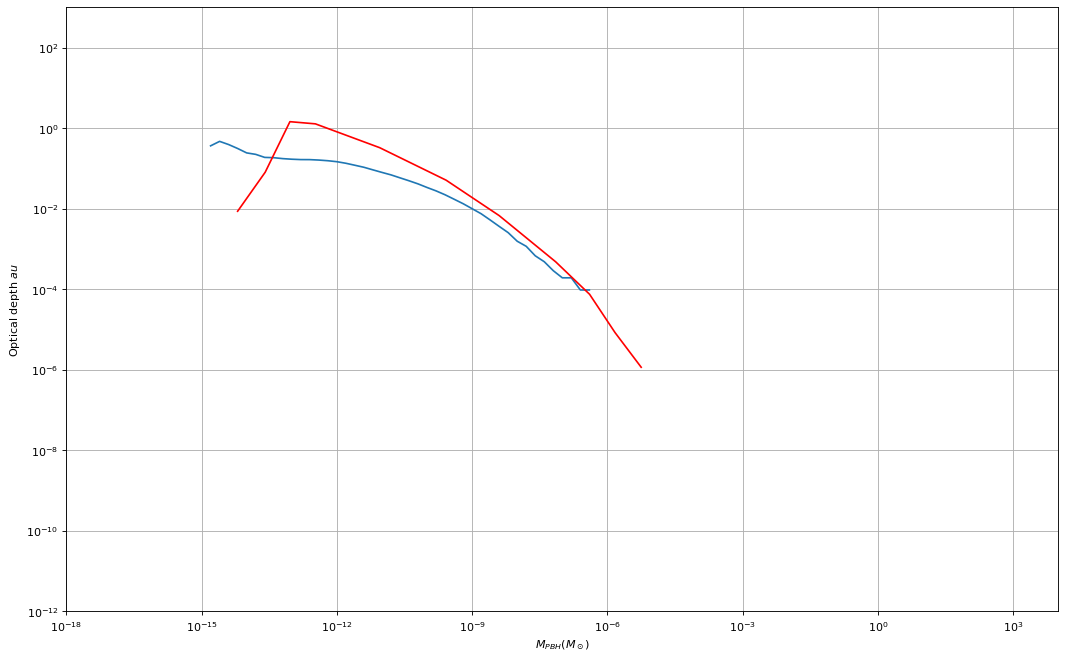

In [107]:
tau = lambda f: n(f) * V_lens_wrapper_2#np.mean(V_lens_wrapper,0)

# Plot Optical Depth vs Mass of lens
plt.figure(figsize=(16,10), dpi=80)
plt.plot(M[1:-2], tau(1)[1:-2])

#plt.title('Optical depth vs Mass \n z = 2, $\Delta$r = $L_2$, $r_S$ = 0.1*$r_\odot$')
plt.xlabel('$M_{PBH} (M_\odot)$')
plt.xscale('log')
plt.ylabel('Optical depth $\tau$')
plt.yscale('log')
plt.ylim([1e-12,1e3])
plt.xlim([1e-18,1e4])
plt.plot(10**def_tau[:,0], 10**def_tau[:,1], c='r')
plt.grid('on')
#plt.axis('off')
plt.savefig('tau_comb.png', transparent = True)

plt.show()

In [42]:
np.savetxt('Simulation 4/mass.csv', M, delimiter = ',')
np.savetxt('Simulation 4/tau.csv', tau(1), delimiter = ',')

In [61]:
tmp_tau = 1e-2
alpha = 1
tmp_tau**alpha*np.exp(-tmp_tau)/np.math.factorial(alpha)

0.009900498337491681

In [43]:
arr = np.genfromtxt('Simulation 4/V_lens_wrapper_with_dist_run_1.csv', delimiter=',')

In [44]:
V_lens_wrapper = arr

In [62]:
def P1(f, k, i):
    tau = lambda f: n(f)[k] * V_lens_wrapper[i,k]
    return (tau(f) * np.exp(-tau(f)))

def calc_P_null(f, k):
    value = 1
    for i in range(1000):
        value *= (1 - P1(f, k, i)) 
    return value

f_final = np.zeros(num_masses)
for k in range(num_masses):
    
    #P_null = calc_P_null(f, k)
    print('Iteration:',k)
    
    num_f = 1000
    f = np.logspace(-5,0,num_f)
    #print(f)
    y_P = np.zeros(num_f)
    y_2 = np.ones(num_f)*0.05
    for i in range(num_f):
        y_P[i] = calc_P_null(f[i],k)
    for l in range(num_f):
        if y_P[l] < 0.05:
            f_final[k] = f[l]
            break

print(f_final)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
[0.02204669 0.01833425 0.01406527 0.01183241 0.01169683 0.01390411
 0.01771121 0.02230223 0.02712898 0.03300035 0.03922777 0.04663035
 0.05607235 0.06742622 0.0810791  0.09862658 0.1227691  0.15459277
 0.19692203 0.25084151 0.33459891 0.46737951 0.65285211 0.9772147
 0.         0.        ]


In [91]:
def_exc = np.genfromtxt('Default Dataset Exclusion Curves 01.csv', delimiter = ',')

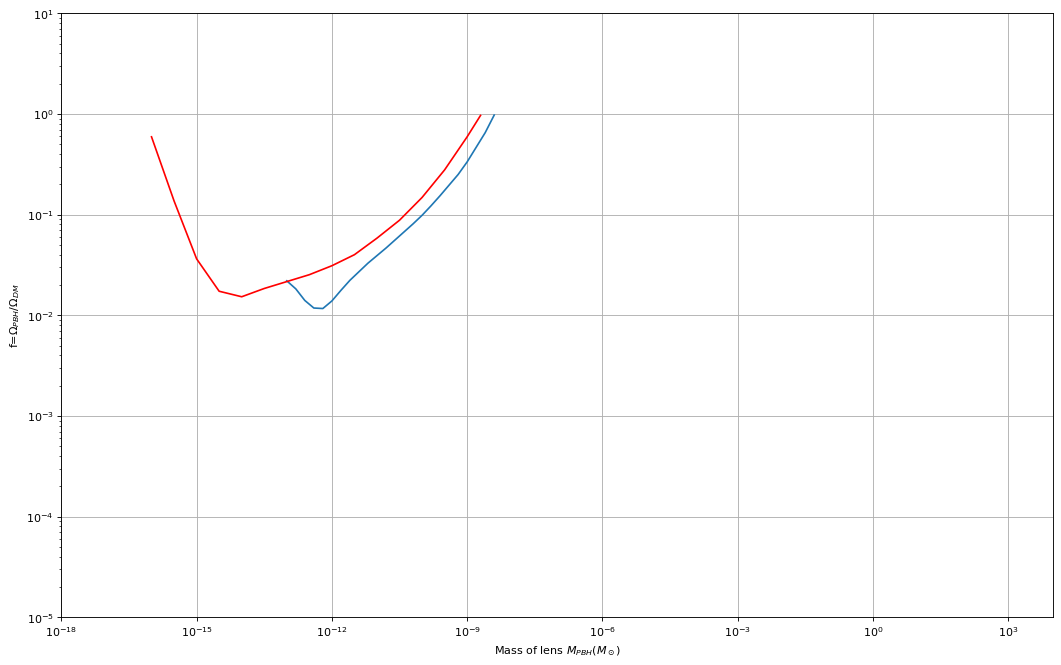

In [94]:
# Plot f vs Mass of lensplt.title('$\Delta_r = L_2$')
plt.figure(figsize=(16, 10), dpi=80)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass of lens $M_{PBH}(M_\odot)$')
plt.ylabel('f=$\Omega_{PBH}/\Omega_{DM}$')
plt.xlim([1e-18,1e4])
plt.ylim([1e-5,1e1])
plt.plot(M[:24],f_final[:24])
plt.plot(10**def_exc[:,0], 10**def_exc[:,1], 'r')
plt.grid('on')
#plt.axis('off')
plt.savefig('exc_comb.png', transparent = True)

In [65]:
np.savetxt("foo.csv", f_final, delimiter=",")

In [53]:
def tmp_func(delta, u):
    A = 0
    if np.abs(u)<=np.abs(0.9*delta):
        A = A_in(u,delta)
        #print(1)
    elif np.abs(u)>=np.abs(1.1*delta):
        A = A_out(u,delta)
        #print(2)
    else:
        A = (A_out(1.1*delta, delta)*(u - 0.9*delta)/(0.2*delta) + A_in(0.9*delta, delta)*(1.1*delta - u)/(0.2*delta))
        #print(3)
    return A

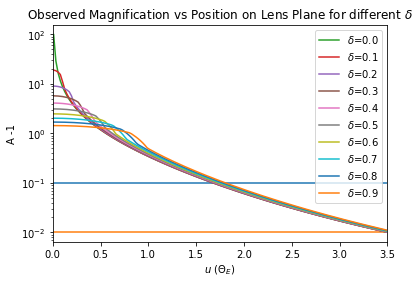

In [85]:
n = 151
tmp_u = np.linspace(0.01,3.5,n)
epsilon=0.1
plt.plot(tmp_u, np.ones(n)*(epsilon))
plt.plot(tmp_u, np.ones(n)*(0.01))
    
for j in range(10):
    delta = j/10

    tmp_A = np.zeros(n)
    for i in range(n):
        tmp_A[i] = tmp_func(delta,tmp_u[i])

#    plt.xscale('log')
    plt.title('Observed Magnification vs Position on Lens Plane for different $\delta$')
    plt.yscale('log')
    plt.xlim(0,3.5)
#    plt.ylim(1e-1,1e2)
    plt.xlabel('$u$ $(\Theta_E)$')
    plt.ylabel('A -1')
    plt.plot(tmp_u,tmp_A - 1,label='$\delta$='+str(1.0*j/10))
    plt.legend()
    
#plt.savefig('diff_delta')